In this exercise I am trying to explore the housing transaction data that I have crawled from Centanet and conduct prediction on the sale price.

In [1]:
# Firstly let's import some libraries
# To manipulate data
import pandas as pd
import seaborn as sn
import numpy as np
from numpy import arange
import json

# To plot graphs
import matplotlib.pyplot as plt
import folium as fl
from folium.plugins import TimeSliderChoropleth

# Machine Learning libraries
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [2]:
# Read data
df = pd.read_csv('../Data Science/Hong Kong House Price/data/cleaned data/cleaned_total_named_extract.csv')


In [3]:
# Understand data structure
df.describe()
df.info()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5154 entries, 0 to 5153
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  5154 non-null   int64  
 1   Date        5154 non-null   object 
 2   Area        5154 non-null   object 
 3   Name        5154 non-null   object 
 4   Years       5154 non-null   int64  
 5   Price..mm.  5154 non-null   float64
 6   Size.sqft.  5154 non-null   int64  
 7   Price/Sqft  5154 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 322.2+ KB


Index(['Unnamed: 0', 'Date', 'Area', 'Name', 'Years', 'Price..mm.',
       'Size.sqft.', 'Price/Sqft'],
      dtype='object')

In [4]:
# Clean up and change into correct structure
df = df.drop(df.columns[0],axis = 1)
df.columns = ['Date', 'Area', 'Name', 'Years', 'Price(mm)', 'Size(sqft)','Price/Sqft']
df.Date = pd.to_datetime(df.Date, format = '%Y-%m-%d')

df['Price(mm)'] = pd.to_numeric(df['Price(mm)'])
df['Price/Sqft'] = pd.to_numeric(df['Price/Sqft'])

In [5]:
df.head()

,Date,Area,Name,Years,Price(mm),Size(sqft),Price/Sqft
0,2021-08-02,Sai Ying Pun,Fung Yat Building,33,4.88,263,18555.133080
1,2021-08-02,Tin Hau,Victoria Centre,39,9.60,539,17810.760668
2,2021-08-02,Sai Wan Ho,Lei King Wan,33,14.15,789,17934.093790
3,2021-08-02,North Point,Island Place,24,15.98,996,16044.176707
4,2021-08-02,North Point Mid-Levels,7A Comfort Terrace,44,9.50,682,13929.618768


The dependent variable in this exercise is Price(mm) and that is the variable that we are trying to predict.

In [6]:
# Check date range
df.Date.describe()

<ipython-input-6-75996e4300cd>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.Date.describe()


count                    5154
unique                     99
top       2021-06-04 00:00:00
freq                      104
first     2021-03-04 00:00:00
last      2021-08-02 00:00:00
Name: Date, dtype: object

Now let's explore the dataset by plotting some graphs between variables to discover any trends.

Text(0.5, 1.0, 'Number of Transaction Across Areas')

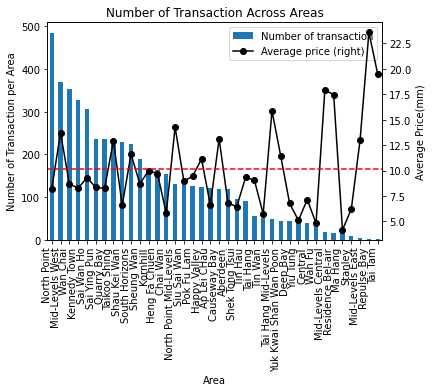

In [7]:
# Plot graph
# Q : Which area has the most transaction by number? 
group = df.groupby(df['Area'])
area = df.groupby('Area').agg(Num_transaction = ('Date','size'),Ave = ('Price(mm)','mean')).sort_values(by = 'Num_transaction',ascending = False).reset_index()

ax1 = area.plot(x = 'Area', y = 'Num_transaction',kind= 'bar', label = 'Number of transaction',legend = True)
ax2 = area['Ave'].plot(secondary_y = True,color = 'k',marker = 'o',label = 'Average price',legend = True)
plt.axhline(y = area['Ave'].mean(),color ='r', linestyle = '--')
ax1.set_ylabel('Number of Transaction per Area')
ax2.set_ylabel('Average Price(mm)')
ax2.set_xlabel('Area')
ax1.set_xticklabels(area.Area,rotation = 90,ha = 'right') 
ax2.set_title('Number of Transaction Across Areas')

Text(0.5, 1.0, 'Number of Transaction Across Areas')

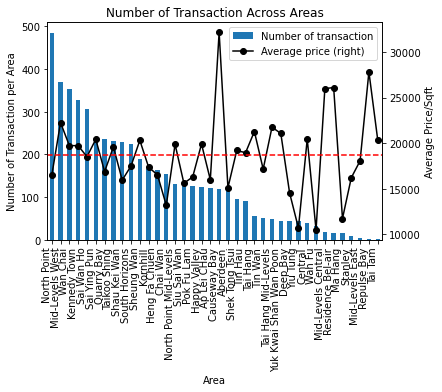

In [8]:
# Q : Which area has the most transaction by average price/sqft? 
group = df.groupby(df['Area'])
area = df.groupby('Area').agg(Num_transaction = ('Date','size'),Ave = ('Price/Sqft','mean')).sort_values(by = 'Num_transaction',ascending = False).reset_index()

ax1 = area.plot(x = 'Area', y = 'Num_transaction',kind= 'bar', label = 'Number of transaction',legend = True)
ax2 = area['Ave'].plot(secondary_y = True,color = 'k',marker = 'o',label = 'Average price',legend = True)
plt.axhline(y = area['Ave'].mean(),color ='r', linestyle = '--')
ax1.set_ylabel('Number of Transaction per Area')
ax2.set_ylabel('Average Price/Sqft')
ax2.set_xlabel('Area')
ax1.set_xticklabels(area.Area,rotation = 90,ha = 'right') 
ax2.set_title('Number of Transaction Across Areas')

It seems like there are some anomalies in Causeway Bay considering it has much higher Average Price/Sqft than Mid-Levels Central or Residence Bel-air.

In [9]:
area.sort_values(by = 'Ave',ascending = False).head()

,Area,Num_transaction,Ave
19,Causeway Bay,120,32176.022513
36,Repulse Bay,1,27830.188679
32,Residence Bel-air,16,26107.444176
31,Mid-Levels Central,19,25993.094724
1,Mid-Levels West,370,22259.022868


We can see that there is a sharp spike in average price(mm) in Causeway Bay. Although there are expensive areas in Causeway Bay but 15% more expensive than Residence Bel-air or Midlevels Central, which are deemed as premium locations in Hong Kong Island, does seem a little off. This has been taken note of and we will investigate this point further.

In [10]:
df.sort_values(by = 'Price(mm)',ascending = False).head()

,Date,Area,Name,Years,Price(mm),Size(sqft),Price/Sqft
3166,2021-05-18,Causeway Bay,5 Sharp Street East,50,606.00,326,1.858896e+06
4403,2021-04-19,Sai Ying Pun,King's Hill,4,43.93,955,4.600000e+04
1462,2021-06-25,Ap Lei CHau,H,4,35.97,959,3.750782e+04
2935,2021-05-25,Wan Chai,Star Crest,21,34.38,898,3.828508e+04
2582,2021-06-01,Mid-Levels West,Arezzo,6,34.00,980,3.469388e+04


Aha! The culprit is found! A unit in 5 Sharp Street East, Causeway Bay cost a whopping HK$606mm for a 50yo building. A quick look on the Internet found out that a developer has been buying up walk up properties around Sharp Street, Causeway Bay. It is not unheard of in Hong Kong that a developer would pay extra to buy up residential units for newer development. Since this unit at 5 Sharp Street completely skews the chart, we decide to remove it.

In [11]:
# Removing anomaly from data
df.iloc[3166]
df = df.drop([3166]) 

In [12]:
# Now we want to study the trend between age of building and number of transaction and average price
# We first discover what is the age range of the building, and then we assign them into respective bins. 
df.Years.describe()

count    5153.000000
mean       32.255773
std        12.841008
min         1.000000
25%        25.000000
50%        33.000000
75%        41.000000
max        70.000000
Name: Years, dtype: float64

In [13]:
# Assigning building ages into respective age bin.
ranges = [0,10,20,30,40,50,60,70]
df['Bins'] = pd.cut(df['Years'],ranges)
age = df.groupby(['Bins']).agg(Ave_px = ('Price(mm)','mean'),Num_tran = ('Price(mm)','size')).reset_index()


Text(0.5, 1.0, 'Number of Transaction Across Building Age Groups')

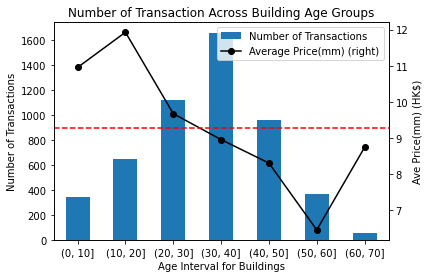

In [14]:
# Visualising trend based on building age
ax1 = age.plot(x = 'Bins', y = 'Num_tran',kind = 'bar', label = 'Number of Transactions',legend = True)
ax2 = age['Ave_px'].plot(secondary_y = True,color = 'k',marker = 'o',label = 'Average Price(mm)',legend = True)
ax1.set_xlabel('Age Interval for Buildings')
ax1.set_ylabel('Number of Transactions')
ax2.set_ylabel('Ave Price(mm) (HK$)')
plt.axhline(y = age['Ave_px'].mean(),color ='r', linestyle = '--')
ax1.set_title('Number of Transaction Across Building Age Groups')


Another anomaly found here. There is an unexpected spike in average price among 60-70year old buildings. We expect the trend to fall continuously hence we will investigate this spike.

Text(0.5, 1.0, 'Number of Transaction Across Building Age Groups')

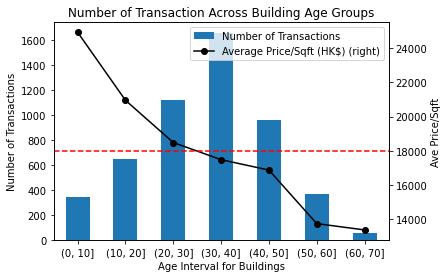

In [20]:
# Plotting building age groups against number of transactions and average price/sqft.
age = df.groupby(['Bins']).agg(Ave_px = ('Price/Sqft','mean'),Num_tran = ('Price/Sqft','size')).reset_index()
ax1 = age.plot(x = 'Bins', y = 'Num_tran',kind = 'bar', label = 'Number of Transactions',legend = True)
ax2 = age['Ave_px'].plot(secondary_y = True,color = 'k',marker = 'o',label = 'Average Price/Sqft (HK$)', legend = True)
ax1.set_xlabel('Age Interval for Buildings')
ax1.set_ylabel('Number of Transactions')
ax2.set_ylabel('Ave Price/Sqft')
plt.axhline(y = age['Ave_px'].mean(),color ='r', linestyle = '--')
ax1.set_title('Number of Transaction Across Building Age Groups')


A quick plot of graph on the average price/sqft confirms our expectation that the average price/sqft decreases with building age. The previous plot shows an increase in absolute price in 60-70 year old building is likely due to larger sizes properties. We will bear in mind on this correlationship when we use Size(sqft) and Years as predictors in our regression model later.

Now we further study what are the statistics relationships between variables. Is our data set normal?

Skewness: 1.419604
Kurtosis: 3.028238


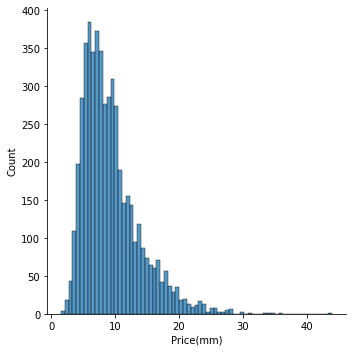

In [23]:
# Histogram on Price(mm) since that is our dependent variable
sn.displot(df['Price(mm)'])  
print("Skewness: %f" % df['Price(mm)'].skew()) 
print("Kurtosis: %f" % df['Price(mm)'].kurt()) 

The plot above shows that our dataset is positively skewed. That means our model will be skewed to better predict properties of price range HK$5-15mm as majority of the dataset is at that range. 

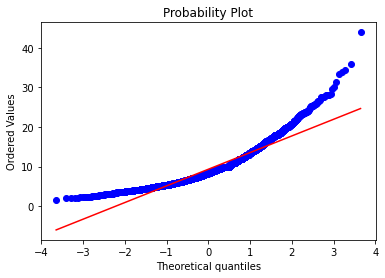

In [24]:
res = stats.probplot(df['Price(mm)'],plot = plt)

Now we explore various statistical relationships between other variables and the target dependent variable

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12'),
  Text(12, 0, '13'),
  Text(13, 0, '14'),
  Text(14, 0, '15'),
  Text(15, 0, '16'),
  Text(16, 0, '17'),
  Text(17, 0, '18'),
  Text(18, 0, '19'),
  Text(19, 0, '20'),
  Text(20, 0, '21'),
  Text(21, 0, '22'),
  Text(22, 0, '23'),
  Text(23, 0, '24'),
  Text(24, 0, '25'),
  Text(25, 0, '26'),
  Text(26, 0, '27'),
  Text(27, 0, '28'),
  Text(28, 0, '29'),
  Text(29, 0, '30'),
  Text(30, 0, '31'),
  Text(31, 0, '32'),
  Text(32, 0, '33'),
  Text(3

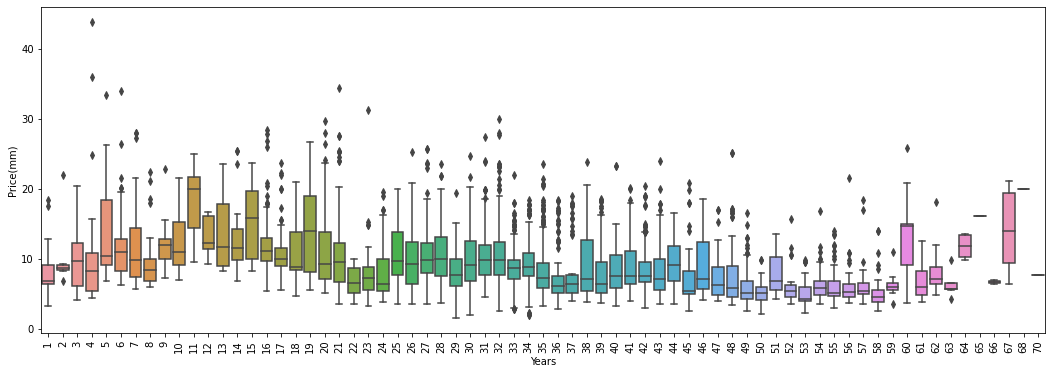

In [25]:
# Building Age vs Price
plt.subplots(figsize=(18, 6))
sn.boxplot(x = 'Years', y = 'Price(mm)', data = df)
plt.xticks(rotation = 90)

The box plot above shows there are quite a lot of outliers among the specific age group. The highest median price belongs to age group of 11 years old. 

<AxesSubplot:xlabel='Size(sqft)', ylabel='Price(mm)'>

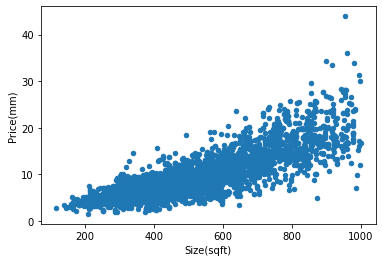

In [26]:
# Scatter plot between size vs price to check relationship.
plt.figsize = (10,6)
df.plot.scatter(x = 'Size(sqft)', y = 'Price(mm)')

The above scatter chart shows that there is a linear relationship between Size(sqft) and Price(mm). Hence that convinces us that perhaps we can use linear regression as the prediction model.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37]),
 [Text(0, 0, 'Sai Ying Pun'),
  Text(1, 0, 'Tin Hau'),
  Text(2, 0, 'Sai Wan Ho'),
  Text(3, 0, 'North Point'),
  Text(4, 0, 'North Point Mid-Levels'),
  Text(5, 0, 'Deep Bay'),
  Text(6, 0, 'Pok Fu Lam'),
  Text(7, 0, 'Mid-Levels West'),
  Text(8, 0, 'Central'),
  Text(9, 0, 'Kennedy Town'),
  Text(10, 0, 'Taikoo Shing'),
  Text(11, 0, 'Quarry Bay'),
  Text(12, 0, 'Tai Hang Mid-Levels'),
  Text(13, 0, 'Kornhill'),
  Text(14, 0, 'Siu Sai Wan'),
  Text(15, 0, 'Causeway Bay'),
  Text(16, 0, 'Tin Wan'),
  Text(17, 0, 'Wan Chai'),
  Text(18, 0, 'Shek Tong Tsui'),
  Text(19, 0, 'Sheung Wan'),
  Text(20, 0, 'Ap Lei CHau'),
  Text(21, 0, 'Yiu Tung'),
  Text(22, 0, 'South Horizons'),
  Text(23, 0, 'Shau Kei Wan'),
  Text(24, 0, 'Happy Valley'),
  Text(25, 0, 'Chai Wan'),
  Text(26, 0, 'Heng Fa Chuen'),
  Text(27, 0, 'W

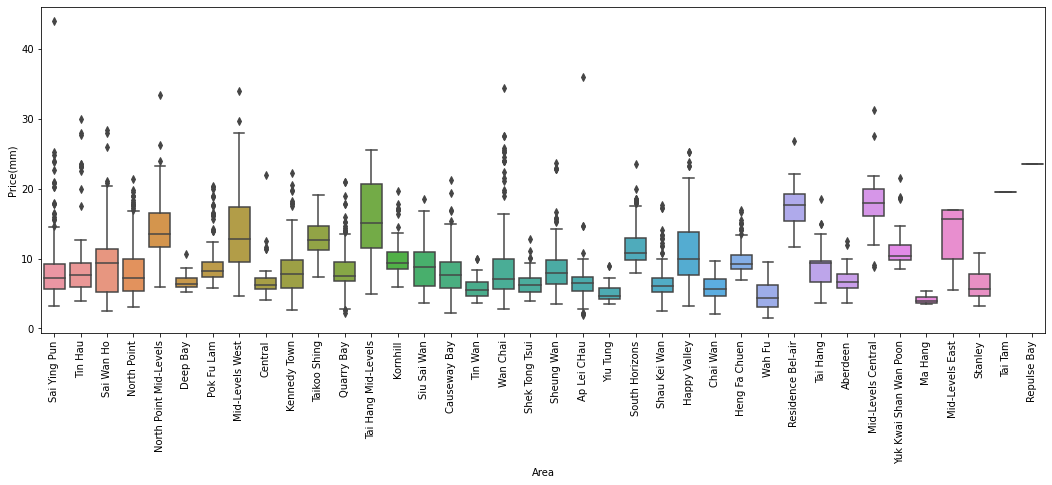

In [27]:
# Area vs Price 
plt.subplots(figsize = (18,6))
sn.boxplot(x = 'Area', y = 'Price(mm)', data = df)
plt.xticks(rotation = 90)


The box plot above shows that Tai Tam, Repulse Bay, Mid Levels Central and Residence Bel-air have the highest median price. However due to the low number of transactions at Tai Tam and Repulse Bay, it is difficult to represent the actual price action in those two respective areas.

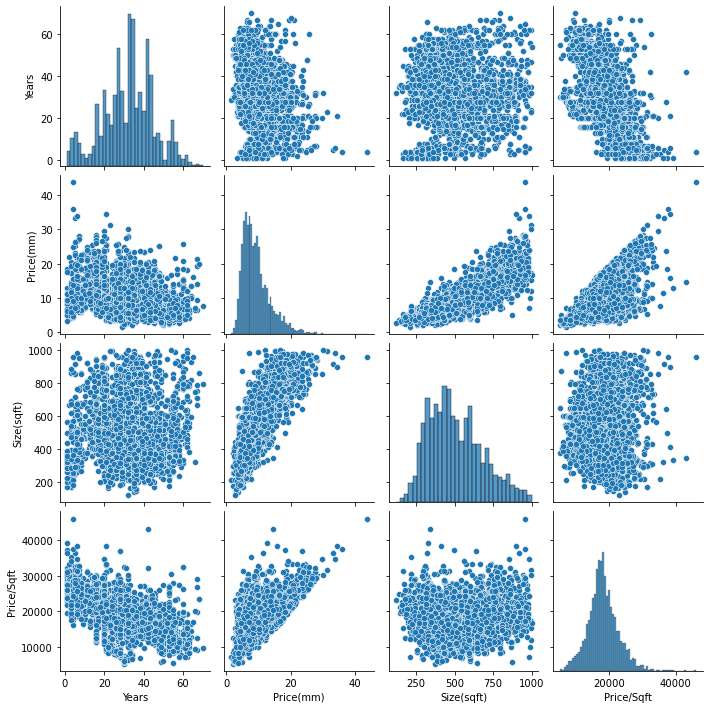

In [28]:
# We continue to plot pair plots to see if we can discover any hidden patterns.
sn.pairplot(df)


The most obvious linear relationship that we can see from above pairplot is Size(sqft). However we will use correlationship heatmap to better see whether we can incorporate other variables in our linear regression model.

<AxesSubplot:>

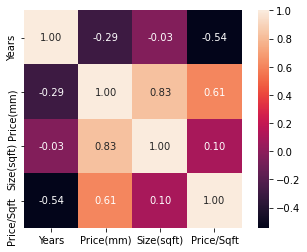

In [29]:
# corrheatmap, seems like only size has positive corr with Price(mm)
corrmat = df.corr()
sn.heatmap(corrmat,annot=True, square=True, fmt='.2f')

Why use linear regression? Because Size and Years seems to be in a linear relationship with Price. But first we will need to normalise the dataset as previously it was shown to be positively skewed. This is to prevent tail distribution to adversely affect the regression model. 

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Price(mm)', ylabel='Density'>

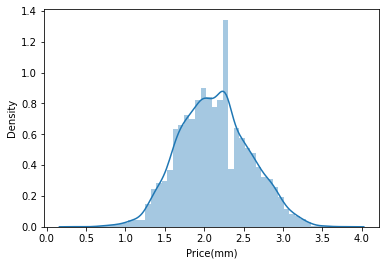

In [30]:
# Use Linear Regression to predict Price based on Size and Years
# Firstly normalise the dataset as linear regression requires 
df['Price(mm)'] = np.log(df['Price(mm)']) # natural log ln
sn.distplot(df['Price(mm)'])



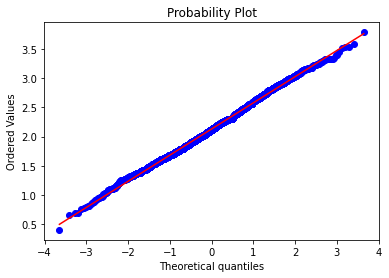

In [31]:
res = stats.probplot(df['Price(mm)'],plot = plt)  

Coefficient:  [-0.00996637  0.00206489]
Mean squared error: 0.05
R2 score: 0.77


Text(0.5, 1.0, 'Residual graph')

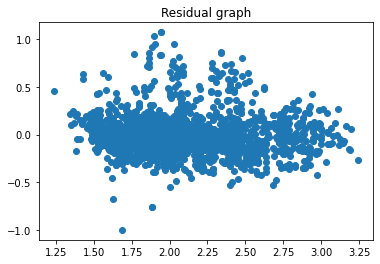

In [32]:
# Split data into test and training data
area_encoder = LabelEncoder()
df['Code'] = area_encoder.fit_transform(df.Area)
X = df[['Years','Size(sqft)']]  # Using Years and Size(sqft) as predictors
y = df['Price(mm)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Linear regression
regr = linear_model.LinearRegression()
regr.fit(X_train,y_train)
y_pred = regr.predict(X_test)
print('Coefficient: ',regr.coef_)
print('Mean squared error: %.2f' % mean_squared_error(y_test,y_pred))
print('R2 score: %.2f' % r2_score(y_test,y_pred))
plt.scatter(y_pred,(y_pred - y_test)) 
plt.title('Residual graph')

comment on the residual graph and see whether this is statistically significant.
In order to see whether I can get a better prediction model, I decide to train my data using Ridge regression.

In [42]:
# Ridge regression
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
model = RidgeCV(alphas=arange(0, 1, 0.01), cv=cv) # In order to select the best alpha for Ridge regression
model.fit(X_train,y_train)
print('model alpha: %f' % model.alpha_)

model alpha: 0.000000


In [43]:
ridge = Ridge(alpha = 0.0)
ridge.fit(X_train,y_train)
y_predRidge = ridge.predict(X_test)
print('Mean squared error: %.2f' %(mean_squared_error(y_test, y_predRidge))) 
print('R2 score: % 0.2f' % r2_score(y_test,y_predRidge)) 

Mean squared error: 0.05
R2 score:  0.77


The R2 score is the same. This result implies the limitation of the dataset. I think there is not sufficient independent variables to improve the regression model. Further improvement on this exercise would be to include more relevant variables such as number of rooms, whether there are facilities in the properties etc.

Next we will conduct time series analysis as part of my learning journey.

In [34]:
#------------------ plotting time series-----------------
# Q: How has number of transaction and ave price change with time
date = df.groupby(df.Date).agg(Num_transaction = ('Date','size'),Ave = ('Price(mm)','mean')).sort_values(by = 'Num_transaction',ascending = False)
date_gp = date.groupby([date.index.year,date.index.month]).agg(total_sum = ('Num_transaction','sum'),ave_price =('Ave','mean'))
date_gp.index = date_gp.index.rename(['Year','Month'])
date_gp['Month'] = date_gp.index


Text(0.5, 1.0, 'Trend change in Number of Transaction and Ave Price')

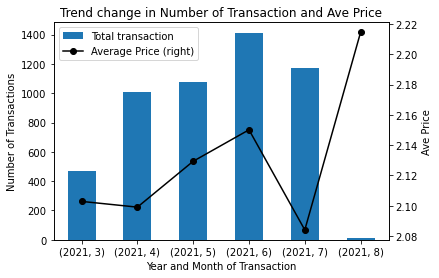

In [36]:
ax1 = date_gp.plot(x = 'Month',y = 'total_sum',kind='bar',label = 'Total transaction',legend = True)
ax2 = date_gp['ave_price'].plot(secondary_y = True,color='k',marker = 'o', label = 'Average Price',legend = True)
ax1.set_xlabel('Year and Month of Transaction')
ax1.set_ylabel('Number of Transactions')
ax2.set_ylabel('Ave Price')
ax2.set_title('Trend change in Number of Transaction and Ave Price')


Remember our date ranges from March 4th to August 2nd, hence the sharp increase in Average Price in August is due to lack of transaction data for August in our dataset, hence skewing the average price higher. This is one of the limitations of our dataset. We see that there is a clear increase in number of transaction and the average price in June.

Before we proceed to conduct time series analysis, we need to check whether our data is stationary, meaning it does not have seasonality or trend effect. If it does we need to remove seasonality effect from the dataset. You can read more below.

https://machinelearningmastery.com/time-series-data-stationary-python/

In [40]:
# Perform Augmented Dicker Fuller test to check stationary
dftest = sm.tsa.adfuller(df['Price(mm)'])  
print('ADF Statistics: %0.2f' % dftest[0])
print('p-value: %0.2f'% dftest[1])


ADF Statistics: -38.12
p-value: 0.00


The -38 ADF statistics and  close to zero p-value in the Augmented Dicker Fuller test show that we can reject the null hypothesis that our data does not have a unit root and it is stationary. Hence it does not need to be transformed for prediction modelling. I plan to explore fbprophet library developed by Facebook in the following analysis. 

In [ ]:
#to be continued with fbprophet